# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings("ignore")

# 0.1 Funções

In [2]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
def metricas_cv(X_train, y_train, nome_modelo, modelo):
    rmse_ = cross_val_score(modelo, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    r2 = cross_val_score(modelo, X_train, y_train, cv=5, scoring="r2")
    mape = cross_val_score(modelo, X_train, y_train, cv=5, scoring="neg_mean_absolute_percentage_error")
    
    resultados = {"Modelo": nome_modelo, "r2_score": (np.mean(r2), np.std(r2)), "Mape": (np.mean(mape), np.std(mape)), "Rmse": (np.mean(rmse_), np.std(rmse_))}
    
    return resultados

In [4]:
def metricas(y_true, y_pred, nome_modelo):
    rmse_ = rmse(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    resultados = {"Modelo": nome_modelo, "r2_score": r2, "Mape": mape, "Rmse": rmse_}
    
    return resultados

# 1. Conhecendo os Dados

## 1.1 Primeiras Linhas

In [5]:
df_raw = pd.read_csv(r"C:/users/leovi/CursoDS/pratica/datasets/kc_house_data.csv")
df_raw.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

## 1.2 Dimensões

In [6]:
print("Numero de linhas:",df_raw.shape[0])
print("Numero de colunas:",df_raw.shape[1])

Numero de linhas: 21613
Numero de colunas: 21


## 1.3 Integridade dos Dados

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## 1.5 Estatísticas Descritivas

In [8]:
df_raw.describe().round(1)

id      price  bedrooms  bathrooms  sqft_living   sqft_lot  \
count  2.161300e+04    21613.0   21613.0    21613.0      21613.0    21613.0   
mean   4.580302e+09   540088.1       3.4        2.1       2079.9    15107.0   
std    2.876566e+09   367127.2       0.9        0.8        918.4    41420.5   
min    1.000102e+06    75000.0       0.0        0.0        290.0      520.0   
25%    2.123049e+09   321950.0       3.0        1.8       1427.0     5040.0   
50%    3.904930e+09   450000.0       3.0        2.2       1910.0     7618.0   
75%    7.308900e+09   645000.0       4.0        2.5       2550.0    10688.0   
max    9.900000e+09  7700000.0      33.0        8.0      13540.0  1651359.0   

        floors  waterfront     view  condition    grade  sqft_above  \
count  21613.0     21613.0  21613.0    21613.0  21613.0     21613.0   
mean       1.5         0.0      0.2        3.4      7.7      1788.4   
std        0.5         0.1      0.8        0.7      1.2       828.1   
min        1.0         0.0      0.0        1.0      1.0       290.0   
25%        1.0         0.0      0.0        3.0      7.0      1190.0   
50%        1.5         0.0      0.0        3.0      7.0      1560.0   
75%        2.0         0.0      0.0        4.0      8.0      2210.0   
max        3.5         1.0      4.0        5.0     13.0      9410.0   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
count        21613.0   21613.0       21613.0  21613.0  21613.0  21613.0   
mean           291.5    1971.0          84.4  98077.9     47.6   -122.2   
std            442.6      29.4         401.7     53.5      0.1      0.1   
min              0.0    1900.0           0.0  98001.0     47.2   -122.5   
25%              0.0    1951.0           0.0  98033.0     47.5   -122.3   
50%              0.0    1975.0           0.0  98065.0     47.6   -122.2   
75%            560.0    1997.0           0.0  98118.0     47.7   -122.1   
max           4820.0    2015.0        2015.0  98199.0     47.8   -121.3   

       sqft_living15  sqft_lot15  
count        21613.0     21613.0  
mean          1986.6     12768.5  
std            685.4     27304.2  
min            399.0       651.0  
25%           1490.0      5100.0  
50%           1840.0      7620.0  
75%           2360.0     10083.0  
max           6210.0    871200.0

In [9]:
np.percentile(df_raw.sqft_lot.values, 90)

21397.599999999995

## 1.6 Engenharia de Variáveis

In [10]:
# Criando uma copia para trabalharmos em cima

df = df_raw.copy()

In [11]:
df["nivel_bairro"] = pd.qcut(df["sqft_living15"].values, q = 4, labels=[1, 2, 3, 4])
df.nivel_bairro = df.nivel_bairro.astype(int)

In [12]:
df["idade_casa"] = 2014 - df.yr_built

In [13]:
df["ja_reformado"] = [0 if i == 0 else 1 for i in df.yr_renovated.values.tolist()]

## 1.7 Limpeza

In [14]:
# Removendo as colunas que não irei usar

df.drop(["sqft_above", "sqft_basement", "sqft_lot15", "yr_built", "yr_renovated", "sqft_living15"], axis=1, inplace=True)

In [15]:
# Removendo alguns outliers extremos já vistos

df.drop(df[df.price > 3000000].index, axis=0, inplace=True)
df.drop(df[df.bedrooms > 10].index, axis=0, inplace=True)
df.drop(df[df.bathrooms > 6].index, axis=0, inplace=True)
df.drop(df[df.sqft_living > 5000].index, axis=0, inplace=True)

# 2. Análise Exploratória

## 2.1 Análise Univariada

### Variável Alvo

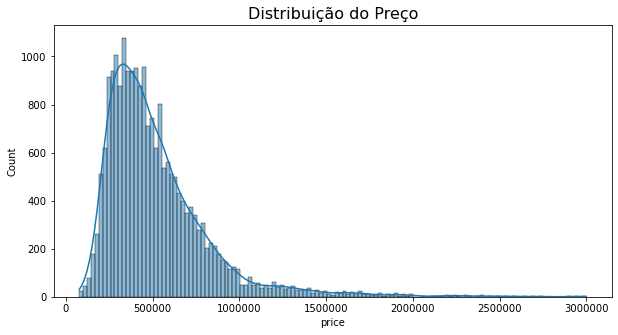

In [16]:
plt.figure(figsize=[10, 5])
sns.histplot(df.price, kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.title("Distribuição do Preço", fontsize=16);

In [17]:
print("Skew:", stats.skew(df.price.values))

Skew: 2.36215224203243


A variável resposta está enviesada positivamente, provavelmente por causa da presença de alguns outliers. Iremos mais a frente tratar esses pontos extremos e caso a distribuição continue enviesada será aplicada uma transformação para uma normal.

### Variáveis explicativas

In [18]:
var_expl = ["bedrooms", "bathrooms", "floors", "waterfront", "view", "condition", "grade", "nivel_bairro", "ja_reformado", "sqft_living", "sqft_lot", "idade_casa"]

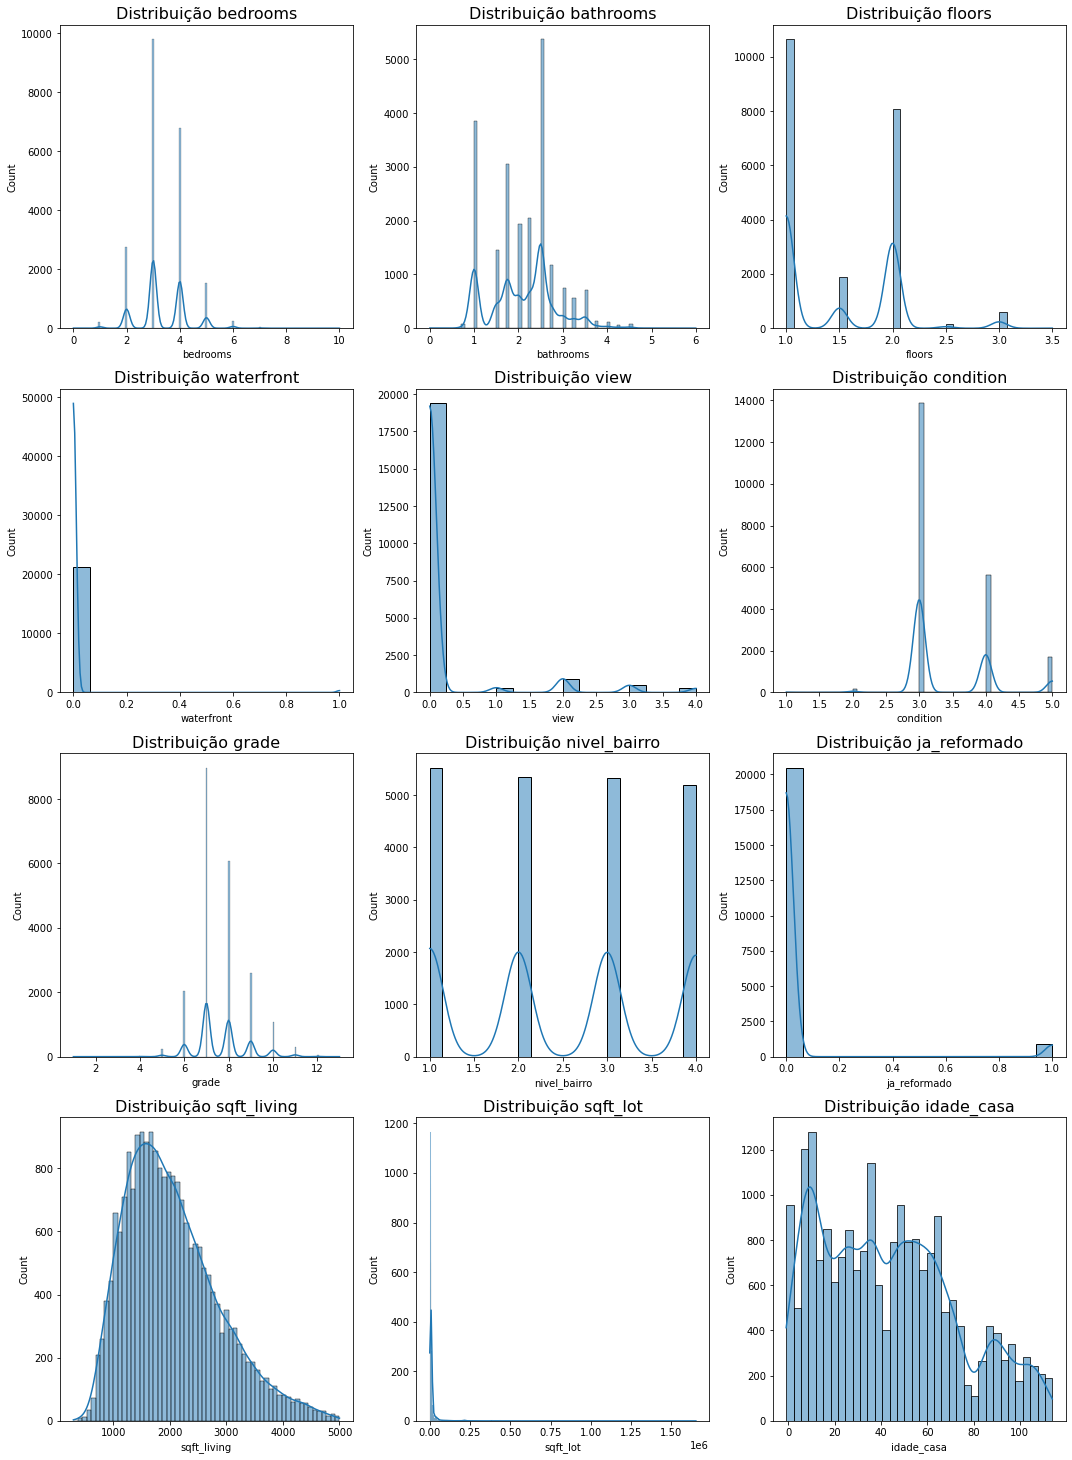

In [19]:
plt.figure(figsize=[15, 25])

for i in var_expl:
    plt.subplot(5, 3, var_expl.index(i) + 1)
    sns.histplot(df[i], kde=True)
    plt.title("Distribuição " + i, fontsize=16)
    plt.tight_layout()
    
plt.show()

1. Poucos são os imóveis com vista para o mar, menos de 1%.
2. 80% dos imóveis a venda tem entre 3 e 4 quartos.
3. 93% dos imóveis não possuem vista ou possuem uma vista péssima.
4. Menos de 1% dos imóveis estão em condições péssimas, a grande maioria, 65% se encontra em condições razoáveis.
5. Apenas 3% dos imóveis já foram reformados.

### Análise e Remoção de Outliers

### Análise Bivariada

Para analisar a dispersão dos outliers irei usar o gráfico boxplot, e a partir da minha interpretação irei escolher como lidar com eles.

In [20]:
var_continuas = ["sqft_living", "sqft_lot", "idade_casa"]
var_discretas = ["bedrooms", "bathrooms", "floors", "waterfront", "view", "condition", "grade", "nivel_bairro", "ja_reformado"]

#### Variáveis continuas

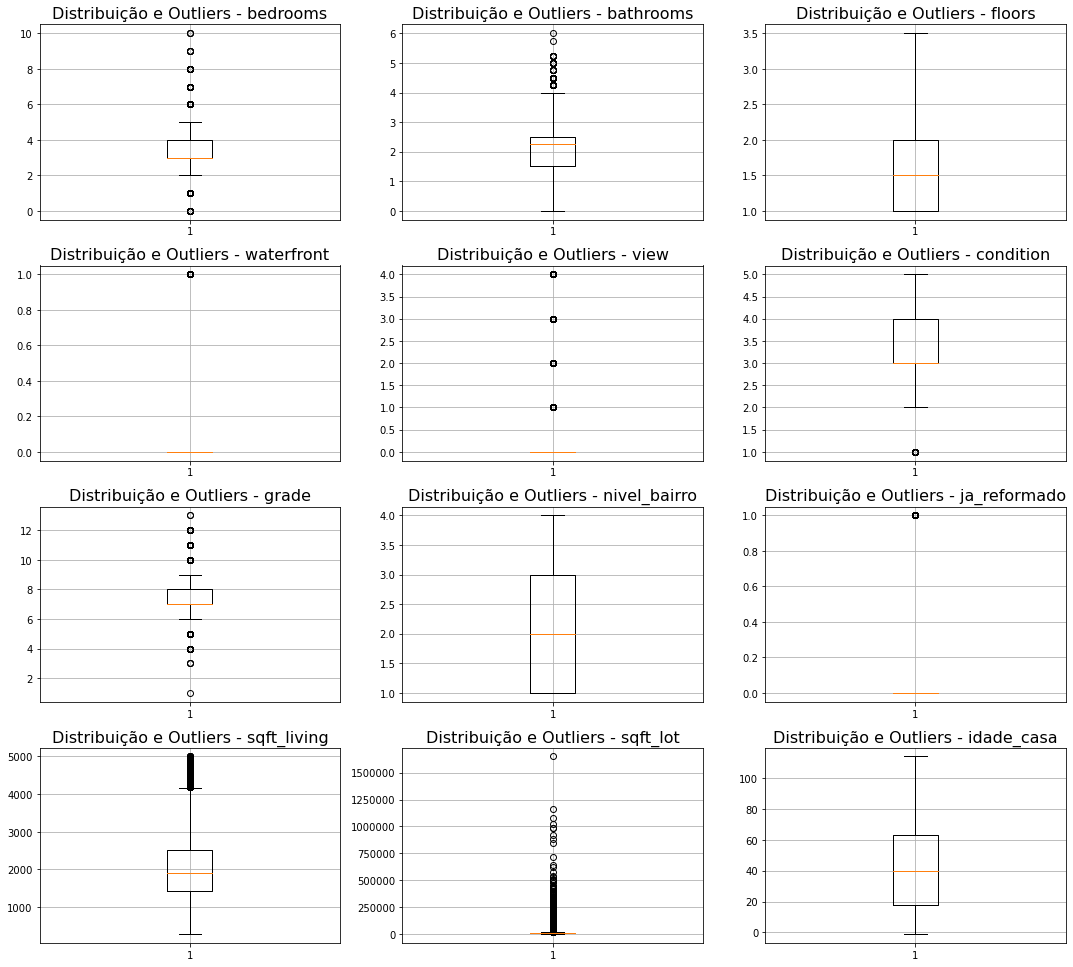

In [21]:
plt.figure(figsize=[15, 20])

for i in var_expl:
    plt.subplot(6, 3, var_expl.index(i) + 1)
    plt.boxplot(df[i])
    plt.title("Distribuição e Outliers - " + i, fontsize=16)
    plt.grid()
    plt.tight_layout()
    plt.ticklabel_format(style='plain', axis='y')
    
plt.show()

Serei um pouco agressivo, removerei todos os outliers com excessão de sqft_living e sqft_lot que irei remover apenas parte dos outliers, waterfront e ja_reformado que são variáveis binárias, view pois todas as categorias são outliers, e longitude pois não faz muito sentido remover estes outliers.

In [22]:
# Removendo outliers

df.drop(df[df.price > 1000000].index, axis=0, inplace=True)
df.drop(df[(df.bedrooms > 5) | (df.bedrooms < 2)].index, axis=0, inplace=True)
df.drop(df[df.bathrooms > 4].index, axis=0, inplace=True)
df.drop(df[df.sqft_living > 4500].index, axis=0, inplace=True)
df.drop(df[df.sqft_lot > 20000].index, axis=0, inplace=True)
df.drop(df[df.condition == 1].index, axis=0, inplace=True)
df.drop(df[(df.grade > 10) | (df.grade < 6)].index, axis=0, inplace=True)

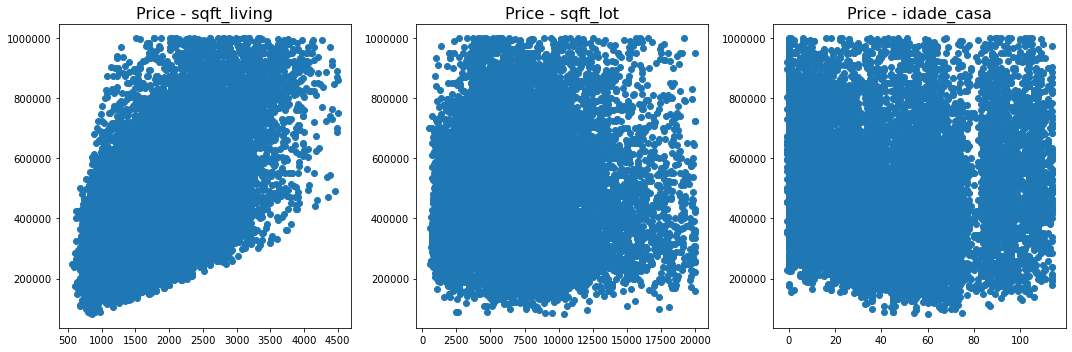

In [23]:
plt.figure(figsize=[15, 5])

for i in var_continuas:
    plt.subplot(1, 3, var_continuas.index(i) + 1)
    plt.scatter(df[i], df["price"])
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.title("Price - " + i, fontsize=16)
    
plt.show()

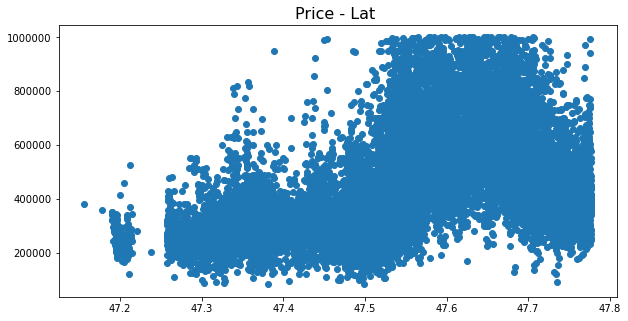

In [71]:
plt.figure(figsize=[10, 5])

plt.scatter(df["lat"], df["price"])
plt.ticklabel_format(style='plain', axis='y')
plt.title("Price - Lat ", fontsize=16)
plt.show()

sqft_living apresenta uma relação linear com o preço, enquanto sqft_lot e idade_casa não aparentam possuir nenhuma relação.

#### Variáveis discretas

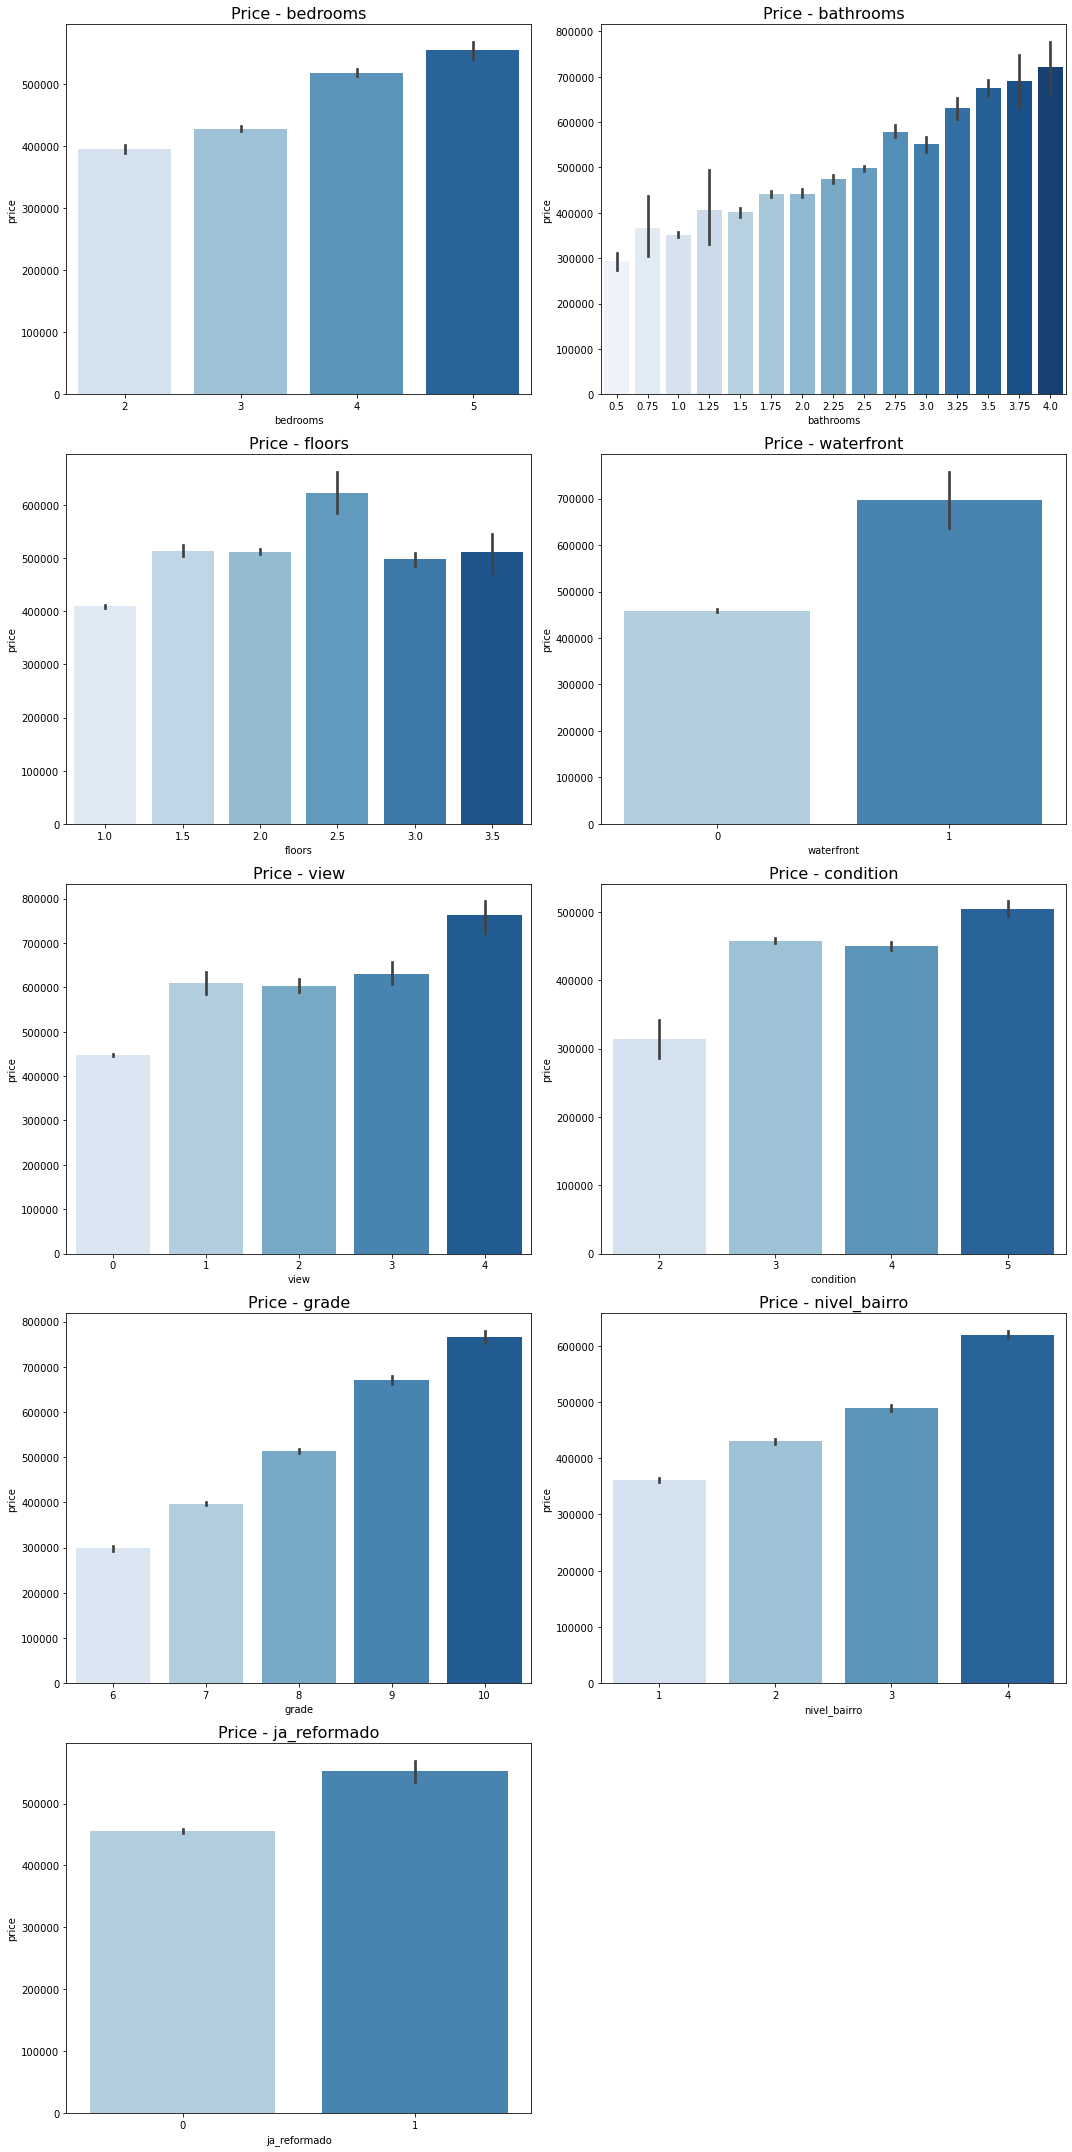

In [24]:
plt.figure(figsize=[15, 30])

for i in var_discretas:
    plt.subplot(5, 2, var_discretas.index(i) + 1)
    sns.barplot(df[i], df.price, palette="Blues")
    plt.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    plt.title("Price - " + i, fontsize=16)
    
plt.show()

In [25]:
plt.figure(figsize=[15, 15])

px.density_mapbox(df, lat='lat', lon='long', z='price', radius=5, zoom=10, mapbox_style="stamen-terrain", )


<Figure size 1080x1080 with 0 Axes>

1. Como esperado, o número de quartos e de banheiros possui uma relação linear com o preço das casas.
2. Imóveis com estruturas e designs mais elaboradas são bem mais caros.
3. Imóveis próximos ao lago Washington possuem os valores mais elevados.
4. Imóveis em Seattle são mais caros.

#### Matrix de Correlação

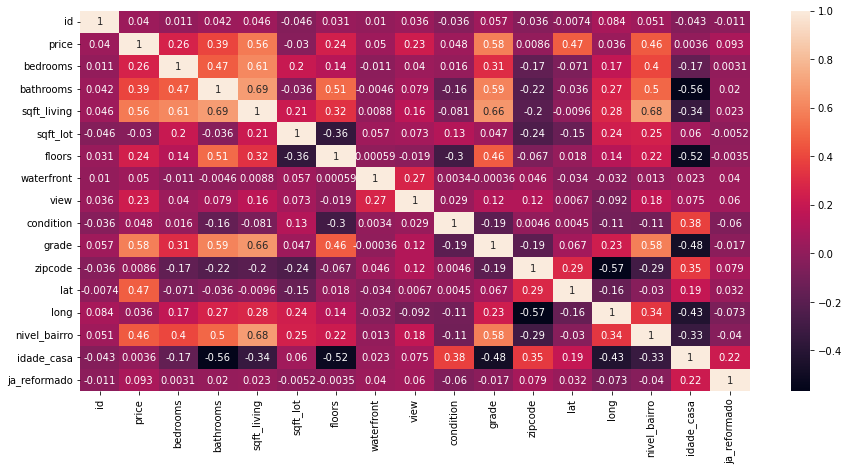

In [62]:
plt.figure(figsize=[15, 7])
sns.heatmap(df.corr(), annot=True);

Os 5 atributos que mais influenciam o preço dos imóveis são, em ordem:
1. O nível de estrutura e design da casa.
2. O tamanho do imóvel.
3. A localização. Latitude.
4. O nível da vizinhança.
5. O numéro de banheiros.

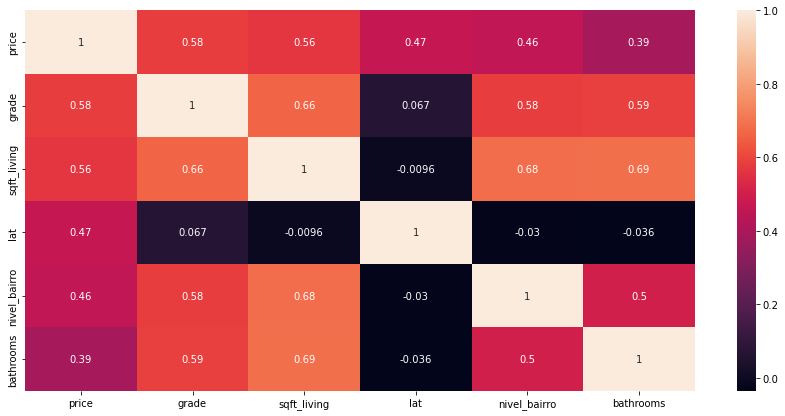

In [69]:
plt.figure(figsize=[15, 7])
sns.heatmap(df[["price", "grade", "sqft_living", "lat", "nivel_bairro", "bathrooms"]].corr(), annot=True);

# 3. Solução 

## 3.1 Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?

In [26]:
df1 = df.copy()

### Imóveis em boas condições que estão abaixo do valor médio de mercado naquela região;

In [27]:
df1["date"] = pd.to_datetime(df1["date"])

df_temp = df1[['zipcode','price']].groupby('zipcode').median().reset_index()
df_temp.columns = ["zipcode", "median_region_price"]

df1 = pd.merge(df_temp, df1, on='zipcode', how='inner')

df_1 = df1[["id", "zipcode", "median_region_price", "price", "condition"]]

df_1["sugestao"] = ["comprar" if row["price"] < row["median_region_price"] and row["condition"] >= 3 else "nao_comprar" for _, row in df_1.iterrows()]
df_1["vantagem_pct"] = [round(((row["median_region_price"] - row["price"]) / row["median_region_price"])*100,1) for _, row in df_1.iterrows()]

In [28]:
df_1[:10]

id  zipcode  median_region_price     price  condition     sugestao  \
0  7895500070    98001             259000.0  240000.0          2  nao_comprar   
1  3717000160    98001             259000.0  287000.0          3  nao_comprar   
2  8961960160    98001             259000.0  480000.0          3  nao_comprar   
3  4014400292    98001             259000.0  465000.0          3  nao_comprar   
4  1115450240    98001             259000.0  360000.0          3  nao_comprar   
5  3353400435    98001             259000.0  230000.0          3      comprar   
6  9262800171    98001             259000.0  252000.0          4      comprar   
7  3353401710    98001             259000.0  227950.0          5      comprar   
8  8159610030    98001             259000.0  196000.0          3      comprar   
9  3329500060    98001             259000.0  305000.0          3  nao_comprar   

   vantagem_pct  
0           7.3  
1         -10.8  
2         -85.3  
3         -79.5  
4         -39.0  
5          11.2  
6           2.7  
7          12.0  
8          24.3  
9         -17.8

- vantagem_pct significa a quanto o valor está abaixo da média em porcentagem, caso a porcentagem esteja negativa significa que aquele valor está tantos porcento acima da média, ou seja, estão caros.

## 3.2 Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?

### Qual trimestre do ano é o melhor para se vender um imóvel em King County?

In [29]:
trimestre = []

for i in df1.date.dt.month:
    if i in [1,2,3]:
        trimestre.append(1)
    elif i in [4,5,6]:
        trimestre.append(2)
    elif i in [7,8,9]:
        trimestre.append(3)
    else:
        trimestre.append(4)
        
df1["trimestre"] = trimestre

In [30]:
df_temp = df1[["trimestre",'price']].groupby(['trimestre']).median().reset_index()
df_temp.columns = ["trimestre", "preco_medio_trimestral"]
df_temp.head()

trimestre  preco_medio_trimestral
0          1                414500.0
1          2                440000.0
2          3                425000.0
3          4                410500.0

In [31]:
df1.trimestre.value_counts()

2    5438
3    4822
4    3849
1    3343
Name: trimestre, dtype: int64

O melhor período do ano para se vender imóveis em King County é no **segundo trimestre do ano, seguido do terceiro, e logo após  o primeiro e o quarto** trimestres que são semelhantes. Isso se baseando no preço médio e no número de negociações no período.

### Qual o melhor valor de venda para cada imóvel?

- O valor de venda deve ser o valor de compra + a diferença para a média + 10%.

In [32]:
df_temp = df1[["zipcode","trimestre",'price']].groupby(['zipcode','trimestre']).median().reset_index()
df_temp.columns = ["zipcode","trimestre", "preco_medio_trimestral"]

df1 = pd.merge(df_temp, df1, on=["zipcode", "trimestre"], how="inner")

df_temp = df_1[["id", "sugestao", "vantagem_pct"]]

df_2 = df1[["id", "zipcode", "trimestre", "preco_medio_trimestral", "price"]]
df_2 = pd.merge(df_temp[df_temp["vantagem_pct"] > -10], df_2, on="id", how="inner")

valor_venda = []

for _, row in df_2.iterrows():
    if row["price"] >= row["preco_medio_trimestral"]:
        valor = row["price"] + (0.1 * row["price"])
        valor_venda.append(valor)
    elif row["price"] < row["preco_medio_trimestral"]:
        valor = row["price"] + (row["preco_medio_trimestral"] - row["price"]) + (0.1 * row["price"])
        valor_venda.append(valor)
    else:
        print("Algo deu errado!")
        
df_2["valor_venda"] = valor_venda
df_2["lucro"] = df_2.valor_venda - df_2.price
df_2["pct_lucro"] = round((df_2.lucro / df_2.price) * 100, 2)

df_2 = df_2[["id", "preco_medio_trimestral", "price", "valor_venda", "lucro", "pct_lucro"]]

In [33]:
df_2

id  preco_medio_trimestral     price  valor_venda     lucro  \
0      7895500070                260000.0  240000.0     284000.0   44000.0   
1      3353400435                252475.0  230000.0     275475.0   45475.0   
2      9262800171                260000.0  252000.0     285200.0   33200.0   
3      3353401710                252475.0  227950.0     275270.0   47320.0   
4      8159610030                252475.0  196000.0     272075.0   76075.0   
...           ...                     ...       ...          ...       ...   
11418  2771604196                619790.0  465000.0     666290.0  201290.0   
11419  2770601457                590000.0  542300.0     644230.0  101930.0   
11420  2770601912                671750.0  570000.0     728750.0  158750.0   
11421  2770601782                619790.0  453000.0     665090.0  212090.0   
11422  6821101731                619790.0  549000.0     674690.0  125690.0   

       pct_lucro  
0          18.33  
1          19.77  
2          13.17  
3          20.76  
4          38.81  
...          ...  
11418      43.29  
11419      18.80  
11420      27.85  
11421      46.82  
11422      22.89  

[11423 rows x 6 columns]

In [34]:
print(f"Lucro com esta estratégia: {df_2.lucro.sum():,.2f}")

Lucro com esta estratégia: 1,149,236,965.70


## 3.3  A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?

1. Uma reforma deve ser realizada caso a condição da casa seja inferior a 3 ou o lucro esperado seja abaixo de 10%.


2. A reforma custa em torno de 5% do valor de compra inicial e pode elevar seu valor em até 30%, mas vamos considerar 20% neste problema.


3. As mudanças sugeridas de acordo com alguns artigos são:
- Concertos simples, por exemplo troca de partes velhas e desgastadas como fiação. (Depende da condição da casa, caso a casa seja bem nova, não acrescentaria muito)
- Reformas na estrutura basica, melhorando o design interior. (ROI mínimo de 50%)
- Transformar espaços vazios em espaços utilizaveis como escritórios, sala de jogos, entre outros. (ROI mínimo esperado de 75%)
- Reforma da cozinha. (Você pode recuperar de 53% a 72% na reforma da cozinha)
- Paisagismo. (ROI esperado de 150% a 1000%)
- Reforma do espaço externo, o deixando mais acessível e útil. (ROI mínimo esperado de 64%)

### Sugestões de casa a serem reformadas

#### Casas em condições ruins ou com lucro esperado inferior a 15%.

In [40]:
df_3 = pd.merge(df_2, df1[["id", "condition"]], on=["id"], how="inner")

reformas = []

for _, row in df_3.iterrows():
    if row["condition"] < 3 or row["pct_lucro"] <=10:
        reformas.append("reformar")
    else:
        reformas.append("nao_reformar")
        
df_3["reformas"] = reformas

valor_pos_reforma = []

for _, row in df_3.iterrows():
    if row["reformas"] == "reformar":
        valor = row["valor_venda"] + 0.2 * row["valor_venda"]
        valor_pos_reforma.append(valor)
    else:
        valor_pos_reforma.append(None)

df_3["investimento_total"] = [row["price"] if row["reformas"]=="nao_reformar" else (row["price"] + 0.05 * row["price"]) 
                              for _, row in df_3.iterrows()]
df_3["valor_pos_reforma"] = valor_pos_reforma
df_3["lucro_reforma"] = df_3["valor_pos_reforma"] - df_3["investimento_total"]
df_3["pct_lucro_reforma"] = np.round((df_3["lucro_reforma"] / df_3["investimento_total"]) * 100, 2)
df_3["valor_venda_final"] = [row["valor_venda"] if row["reformas"]=="nao_reformar" else row["valor_pos_reforma"] 
                             for _, row in df_3.iterrows()]
df_3["lucro_final"] = [row["lucro"] if row["reformas"]=="nao_reformar" else row["lucro_reforma"] 
                       for _, row in df_3.iterrows()]
df_3["pct_lucro_final"] = round((df_3["lucro_final"] / df_3["investimento_total"] ) * 100, 2)
df_3["valor_reforma"] =[0.05 * row["valor_venda"] if row["reformas"]=="reformar" else 0 for _, row in df_3.iterrows()]


df_4 = df_3[["id", "price", "valor_reforma", "investimento_total", "valor_venda_final", "lucro_final","pct_lucro_final", "reformas"]]
df_4.columns = ["id", "preco_inicial", "valor_reforma","preco_final", "valor_venda_final","lucro_final","pct_lucro_final", "reformas"]

In [41]:
df_4.head()

id  preco_inicial  valor_reforma  preco_final  valor_venda_final  \
0  7895500070       240000.0        14200.0     252000.0           340800.0   
1  3353400435       230000.0            0.0     230000.0           275475.0   
2  9262800171       252000.0            0.0     252000.0           285200.0   
3  3353401710       227950.0            0.0     227950.0           275270.0   
4  8159610030       196000.0            0.0     196000.0           272075.0   

   lucro_final  pct_lucro_final      reformas  
0      88800.0            35.24      reformar  
1      45475.0            19.77  nao_reformar  
2      33200.0            13.17  nao_reformar  
3      47320.0            20.76  nao_reformar  
4      76075.0            38.81  nao_reformar

In [52]:
print(f"Casas a reformasr: {df_4.reformas.value_counts()[1]}")

Casas a reformasr: 2845


In [42]:
print(f"Lucro com as reformas: {df_3.lucro_final.sum() - df_2.lucro.sum():,.2f}")

Lucro com as reformas: 272,456,178.42


##  Retorno total esperado

In [43]:
total_investido = np.sum(df_4.preco_final.values)
retorno_bruto = np.sum(df_4.valor_venda_final.values)
lucro_total = np.sum(df_4.lucro_final.values)

In [44]:
print(f"Total Investido: {total_investido:,.2f}")
print(f"Retorno Bruto: {retorno_bruto:,.2f}")
print(f"Lucro Total: {lucro_total:,.2f}")
print(f"Lucro Total em %: {(lucro_total / total_investido)*100:.2f}")

Total Investido: 4,592,673,516.80
Retorno Bruto: 6,014,366,660.92
Lucro Total: 1,421,693,144.12
Lucro Total em %: 30.96
